<a href="https://colab.research.google.com/github/Mars0827/Hum-AI-Thesis-Model/blob/main/HumAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install the ultralytics package (supports YOLOv8 and YOLO11)
!pip install ultralytics roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 75.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 110.9 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11


In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="LVbqdyxVE0PjuOkpwg04")
project = rf.workspace("snoopgoy").project("rice_object_detection-npimg")
version = project.version(1)
dataset = version.download("yolov11")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to rice_object_detection--1 in yolov11:: 100%|██████████| 9964/9964 [00:01<00:00, 5268.61it/s]


In [ ]:
# Install Ultralytics for YOLOv11 and OpenCV for image processing
%pip install ultralytics opencv-python-headless numpy matplotlib
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow # Helper for Colab display

print("Setup Complete. Ready to train!")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Setup Complete. Ready to train!


In [ ]:
model = YOLO('yolo11n.pt')

# Train for 50-100 epochs for best results
results = model.train(
    data=f"{dataset.location}/data.yaml",
    epochs=50,
    imgsz=640,
    plots=True
)

print("Training finished! Model saved to runs/detect/train/weights/best.pt")

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/rice_object_detection--1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plo

In [ ]:
class NCTGrader:
    def __init__(self, pixels_per_mm):
        self.px_per_mm = pixels_per_mm

    def get_dimensions(self, box):
        """
        Converts bounding box pixels to millimeters.
        YOLO Box format: [x1, y1, x2, y2]
        """
        x1, y1, x2, y2 = box
        length_px = max(x2-x1, y2-y1) # Longest side is length
        width_px = min(x2-x1, y2-y1)  # Shortest side is width

        length_mm = length_px / self.px_per_mm
        width_mm = width_px / self.px_per_mm
        return length_mm, width_mm

    def check_chalkiness(self, image_roi):
        """
        Simple computer vision to detect white/chalky areas.
        Returns True if chalky area > 50% of grain.
        """
        # Convert to Gray and Threshold for "White" spots
        gray = cv2.cvtColor(image_roi, cv2.COLOR_BGR2GRAY)
        # Threshold: Pixels brighter than 200 (out of 255) are considered "Chalky"
        _, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)

        white_pixels = cv2.countNonZero(thresh)
        total_pixels = image_roi.shape[0] * image_roi.shape[1]
        chalk_ratio = white_pixels / total_pixels

        return chalk_ratio > 0.50  # If >50% white, it's chalky

    def grade_grain(self, length_mm, width_mm):
        """
        Applies NCT Table 3 Rules (Page 182)
        """
        # Length Classification
        if length_mm >= 7.5: len_class = "Extra Long"
        elif 6.6 <= length_mm <= 7.4: len_class = "Long"
        elif 5.5 <= length_mm <= 6.5: len_class = "Medium"
        else: len_class = "Short"

        # Shape Classification (Length / Width)
        ratio = length_mm / width_mm if width_mm > 0 else 0
        if ratio > 3.0: shape_class = "Slender"
        elif 2.1 <= ratio <= 3.0: shape_class = "Intermediate"
        else: shape_class = "Bold"

        return len_class, shape_class

Found 272 images. Starting analysis...

[1] Analyzing: 59_png_jpg.rf.54bc658e5c0994179ffa2edd2393af8c.jpg...

   NCT RICE QUALITY ANALYSIS REPORT
Total Objects Detected: 39
----------------------------------------
HEAD RICE (Whole):      0    (2.56%)
BROKEN RICE:            0    (0.00%)
CHALKY GRAINS:          0    (0.00%)
IMMATURE GRAINS:        0    (0.00%)
DISCOLORED/DAMAGED:     38   (97.44%)
FOREIGN MATTER:         0    (Count)
----------------------------------------
OFFICIAL GRADE:         FAIL / BELOW GRADE 3



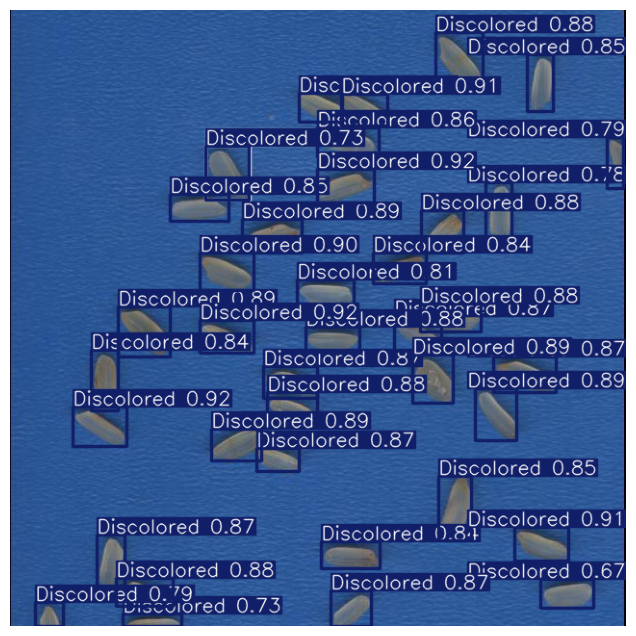

[2] Analyzing: 51_png_jpg.rf.a70b31c6709931df1a999bd624412382.jpg...

   NCT RICE QUALITY ANALYSIS REPORT
Total Objects Detected: 38
----------------------------------------
HEAD RICE (Whole):      0    (5.26%)
BROKEN RICE:            36   (94.74%)
CHALKY GRAINS:          0    (0.00%)
IMMATURE GRAINS:        0    (0.00%)
DISCOLORED/DAMAGED:     0    (0.00%)
FOREIGN MATTER:         0    (Count)
----------------------------------------
OFFICIAL GRADE:         FAIL / BELOW GRADE 3



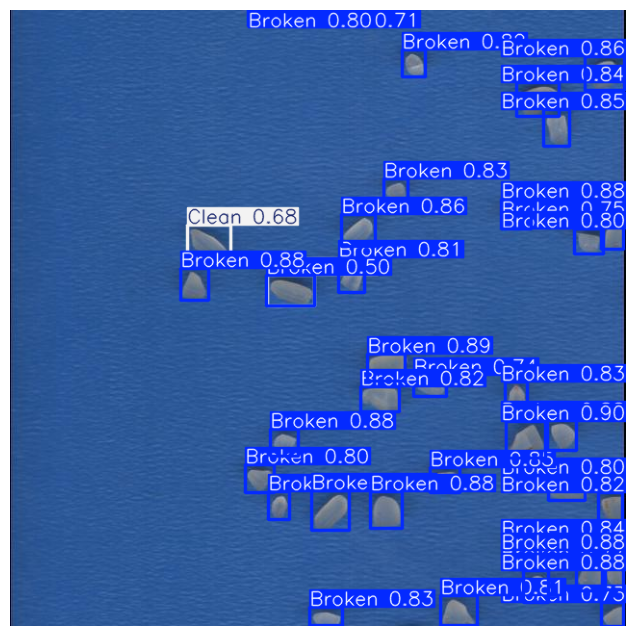

[3] Analyzing: 105_png_jpg.rf.994e12bc40e90ca1e98f5e734b0ec70d.jpg...

   NCT RICE QUALITY ANALYSIS REPORT
Total Objects Detected: 44
----------------------------------------
HEAD RICE (Whole):      0    (88.64%)
BROKEN RICE:            0    (0.00%)
CHALKY GRAINS:          0    (0.00%)
IMMATURE GRAINS:        5    (11.36%)
DISCOLORED/DAMAGED:     0    (0.00%)
FOREIGN MATTER:         0    (Count)
----------------------------------------
OFFICIAL GRADE:         GRADE 3



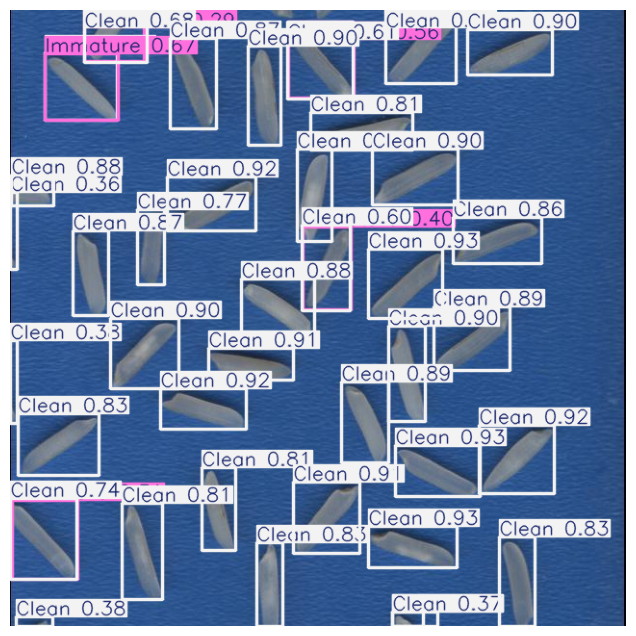

[4] Analyzing: 170_png_jpg.rf.80fb352eb9744ef101a3c23a21d26553.jpg...

   NCT RICE QUALITY ANALYSIS REPORT
Total Objects Detected: 24
----------------------------------------
HEAD RICE (Whole):      0    (100.00%)
BROKEN RICE:            0    (0.00%)
CHALKY GRAINS:          0    (0.00%)
IMMATURE GRAINS:        0    (0.00%)
DISCOLORED/DAMAGED:     0    (0.00%)
FOREIGN MATTER:         0    (Count)
----------------------------------------
OFFICIAL GRADE:         PREMIUM



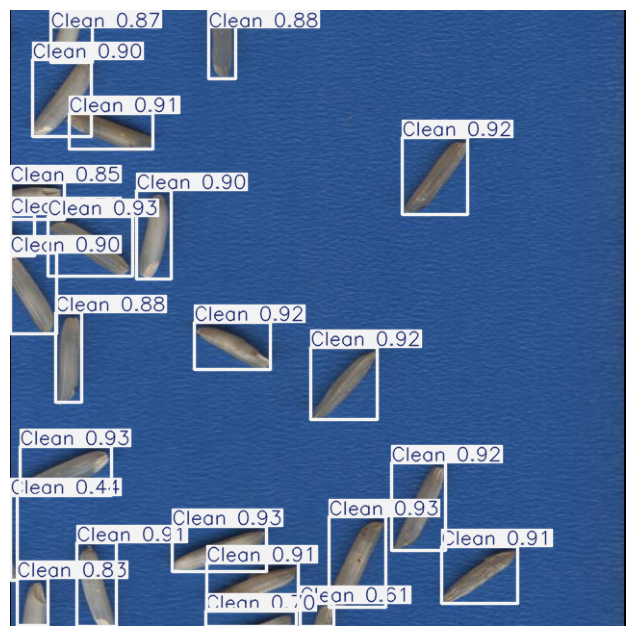

[5] Analyzing: 33_png_jpg.rf.cde615e386858c82a39cb68689975a72.jpg...

   NCT RICE QUALITY ANALYSIS REPORT
Total Objects Detected: 9
----------------------------------------
HEAD RICE (Whole):      0    (88.89%)
BROKEN RICE:            1    (11.11%)
CHALKY GRAINS:          0    (0.00%)
IMMATURE GRAINS:        0    (0.00%)
DISCOLORED/DAMAGED:     0    (0.00%)
FOREIGN MATTER:         0    (Count)
----------------------------------------
OFFICIAL GRADE:         PREMIUM



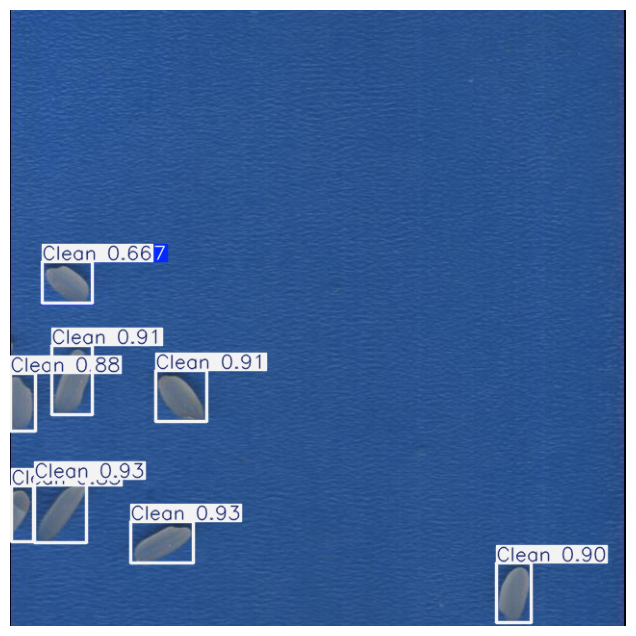

In [ ]:
import glob
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# --- 1. SETUP & LOAD MODEL ---
# Load your specific trained model weights
model = YOLO('/content/runs/detect/train/weights/best.pt')

# Locate Test Images
test_images = glob.glob(f"{dataset.location}/test/images/*.jpg")
if len(test_images) == 0:
    test_images = glob.glob(f"{dataset.location}/valid/images/*.jpg")

print(f"Found {len(test_images)} images. Starting analysis...\n")

# --- 2. PROCESSING LOOP ---
for i, target_image_path in enumerate(test_images[:5]): # Analyze first 5 images
    print(f"[{i+1}] Analyzing: {target_image_path.split('/')[-1]}...")

    # Run Inference
    results = model.predict(target_image_path, conf=0.25, verbose=False)
    result = results[0] # Get first result

    # Initialize Counters based on YOUR trained classes
    counts = {
        'Whole': 0,          # Head Rice
        'Broken': 0,
        'Chalky': 0,
        'Discolored': 0,     # Damaged/Discolored
        'Immature': 0,
        'Foreign Object': 0, # Organic/Inorganic Matter
        'Clean': 0           # Assuming 'Clean' maps to Whole/Good if present
    }

    # Count Detections
    for box in result.boxes:
        class_id = int(box.cls[0])
        class_name = model.names[class_id]

        # Normalize class names to match counters if needed
        if class_name in counts:
            counts[class_name] += 1
        elif class_name == 'Damaged': # Handle potential naming variations
            counts['Discolored'] += 1
        else:
            print(f"Warning: Unknown class detected: {class_name}")

    # --- 3. CALCULATE METRICS (NCT STANDARDS) ---
    # Total Grains = Whole + Broken + Chalky + Discolored + Immature
    # Foreign Objects are excluded from the denominator for grain percentages
    total_grains = (counts['Whole'] + counts['Broken'] + counts['Chalky'] +
                    counts['Discolored'] + counts['Immature'] + counts['Clean'])

    if total_grains > 0:
        # Calculate Percentages
        head_rice_pct = ((counts['Whole'] + counts['Clean']) / total_grains) * 100
        broken_pct = (counts['Broken'] / total_grains) * 100
        chalky_pct = (counts['Chalky'] / total_grains) * 100
        immature_pct = (counts['Immature'] / total_grains) * 100
        discolored_pct = (counts['Discolored'] / total_grains) * 100
    else:
        head_rice_pct = broken_pct = chalky_pct = immature_pct = discolored_pct = 0

    # --- 4. DETERMINE NCT GRADE ---
    # Logic derived from NCT Manual Chapter XVI (Tables 2 & 4)
    # Premium: Head Rice >= 57%, Chalky < 2.0%, Immature < 2.0%
    # Grade 1: Head Rice 48-56.9%, Chalky 2-5%, Immature 2-5%
    # Grade 2: Head Rice 39-47.9%, Chalky 5.1-10%, Immature 5.1-10%
    # Grade 3: Head Rice 30-38.9%, Chalky 10.1-15%, Immature 10.1-15%

    grade = "FAIL / BELOW GRADE 3" # Default

    # We evaluate from Highest (Premium) down to Lowest
    if (counts['Foreign Object'] == 0 and
        discolored_pct <= 0.5 and
        head_rice_pct >= 57.0 and
        chalky_pct < 2.0 and
        immature_pct < 2.0):
        grade = "PREMIUM"

    elif (counts['Foreign Object'] == 0 and
          discolored_pct <= 2.0 and
          head_rice_pct >= 48.0 and
          chalky_pct <= 5.0 and
          immature_pct <= 5.0):
        grade = "GRADE 1"

    elif (head_rice_pct >= 39.0 and
          chalky_pct <= 10.0 and
          immature_pct <= 10.0):
        grade = "GRADE 2"

    elif (head_rice_pct >= 30.0 and
          chalky_pct <= 15.0 and
          immature_pct <= 15.0):
        grade = "GRADE 3"

    # --- 5. PRINT REPORT ---
    print("\n" + "="*40)
    print("   NCT RICE QUALITY ANALYSIS REPORT")
    print("="*40)
    print(f"Total Objects Detected: {total_grains + counts['Foreign Object']}")
    print("-" * 40)
    print(f"HEAD RICE (Whole):      {counts['Whole']:<4} ({head_rice_pct:.2f}%)")
    print(f"BROKEN RICE:            {counts['Broken']:<4} ({broken_pct:.2f}%)")
    print(f"CHALKY GRAINS:          {counts['Chalky']:<4} ({chalky_pct:.2f}%)")
    print(f"IMMATURE GRAINS:        {counts['Immature']:<4} ({immature_pct:.2f}%)")
    print(f"DISCOLORED/DAMAGED:     {counts['Discolored']:<4} ({discolored_pct:.2f}%)")
    print(f"FOREIGN MATTER:         {counts['Foreign Object']:<4} (Count)")
    print("-" * 40)
    print(f"OFFICIAL GRADE:         {grade}")
    print("="*40 + "\n")

    # Display Result Image
    plt.figure(figsize=(8, 8))
    # Convert BGR to RGB for matplotlib
    res_plotted = result.plot()
    plt.imshow(cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [ ]:
from google.colab import files

# This is the default path where YOLO saves the best model
model_path = '/content/runs/detect/train/weights/grain_quality_detector.pt'

# Trigger the download
files.download(model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>